# Bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [2]:
# Caminho relativo para o diretorio do banco de dados
path = "esc10"

# Banco de dados

O banco de dados utilizado chama-se **ESC-10**, consiste em 400 áudios rotulados em 10 classes:

Constituido por três grupos:

- sons transitórios/percussivos, às vezes com padrões temporais muito significativos (espirros, latidos de cachorro, relógio),
- eventos sonoros com forte conteúdo harmônico (choro de bebê e galo cantando)
- ruído/paisagens sonoras mais ou menos estruturadas (chuva, mar e ondas, crepitar de fogo, helicóptero, motosserra).

Artigo: https://www.karolpiczak.com/papers/Piczak2015-ESC-Dataset.pdf

In [3]:
# Meta dados 
df = pd.read_csv(os.path.join(path, 'esc50.csv'))
df.drop('fold', axis=1)

# Filtragem as classes
df = df[df.esc10 == True]
classes = df.category.unique()

Com as classes filtradas, segue a distribuição das classes. Observa-se que as classes estão igualmente distribuidas, com 40 exemplos para cada.

In [4]:
df.category.value_counts()

dog               40
chainsaw          40
crackling_fire    40
helicopter        40
rain              40
crying_baby       40
clock_tick        40
sneezing          40
rooster           40
sea_waves         40
Name: category, dtype: int64

Alguns exemplos:

In [5]:
import IPython.display as ipd

In [6]:
for c in classes[:5]:
    print(c)
    sample = df[df.category == c].sample()
    filename = sample.iloc[0].filename
    ipd.display(ipd.Audio(os.path.join(path, "audio", filename)))

dog


chainsaw


crackling_fire


helicopter


rain


# Pré-processamento

Inicialmente, é preciso verificar se há alguma inconsistência nos dados.

Abaixo, verificamos que não há valores nulos em nenhum campo.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  400 non-null    object
 1   fold      400 non-null    int64 
 2   target    400 non-null    int64 
 3   category  400 non-null    object
 4   esc10     400 non-null    bool  
 5   src_file  400 non-null    int64 
 6   take      400 non-null    object
dtypes: bool(1), int64(3), object(3)
memory usage: 22.3+ KB


Com isso, podemos verificar se os nomes das imagens (filename) são válidos e a duração dos áudios, é esperado que os áudios tenham 5 segundos.

In [8]:
# Esta biblioteca é utilizada para leitura dos audios
# %pip install librosa
import librosa
import librosa.display

In [9]:
for filename in df.filename.values:
    audio_path = os.path.join(path, "audio", filename)
    assert librosa.get_duration(filename=audio_path) == 5

print("Nenhuma erro encontrado!")

Nenhuma erro encontrado!


Por fim, o formato do áudio ".wav" não é adequado para aplicar os algoritmos de Machine Learning que serão testados. Dessa forma, ser~ao utilizadas algumas técnicas para extração de *features*, como: o MFCC (*Mel-Frequency Cepstral Coefficients*). 

- MFCC - Essa técnica, resumidamente, é baseada nas transformadas de Fourier e permite representar o sinal em poucos coeficientes.

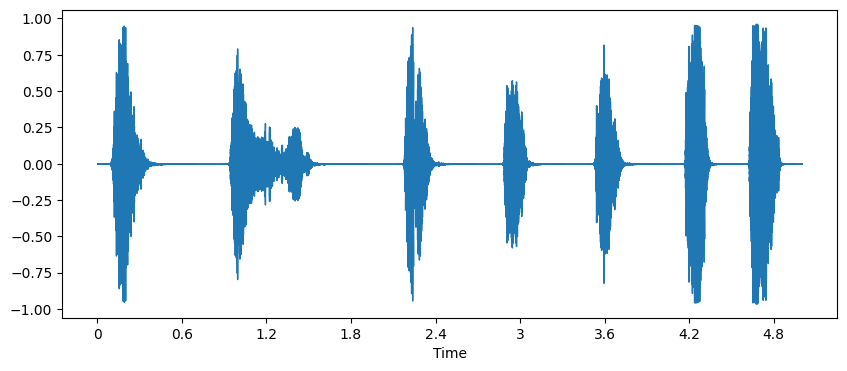

In [10]:
# Exemplo
audio_path = os.path.join(path, 'audio', '2-114280-A-0.wav')

# Dados do audio (x) e taxa de amostragem (sr).
x, sr = librosa.load(audio_path)

# Plot do sinal
plt.figure(figsize=(10, 4))
librosa.display.waveshow(x, sr=sr)
plt.show()

# Audio
ipd.Audio(audio_path)

MFCCs shape: (13, 216)


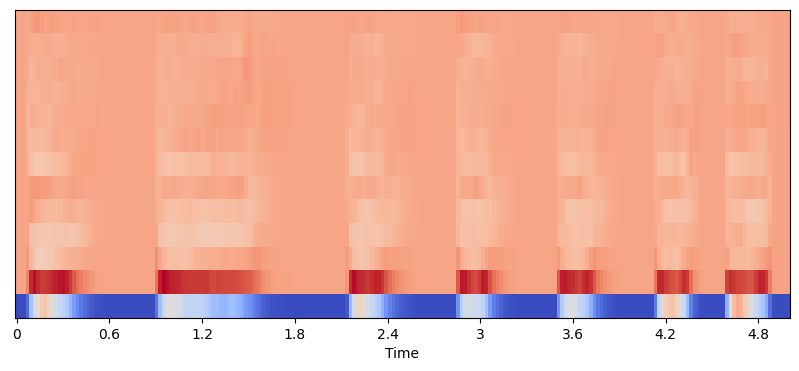

In [11]:
# Extracao de features com MFCC
mfccs = librosa.feature.mfcc(y=x, n_mfcc=13, sr=sr)
print(f'MFCCs shape: {mfccs.shape}')

# Plot do spectograma 
plt.figure(figsize=(10, 4))
librosa.display.specshow(data=mfccs, sr=sr, x_axis='time')
plt.show()

In [12]:
# Média Desvio padrao dos coeficientes ao longo dos frames
mfccs_mean = mfccs.mean(axis=1)[1:]
mfccs_std = mfccs.std(axis=1)[1:]

A partir disso, podemos construir um vetor que represente o áudio e será utilizado como entrada dos modelos.
Esse vetor será formado pela média e desvio padrão do MFCC, o qual é aplicado em pequenos intervalos ao longo do áudio.

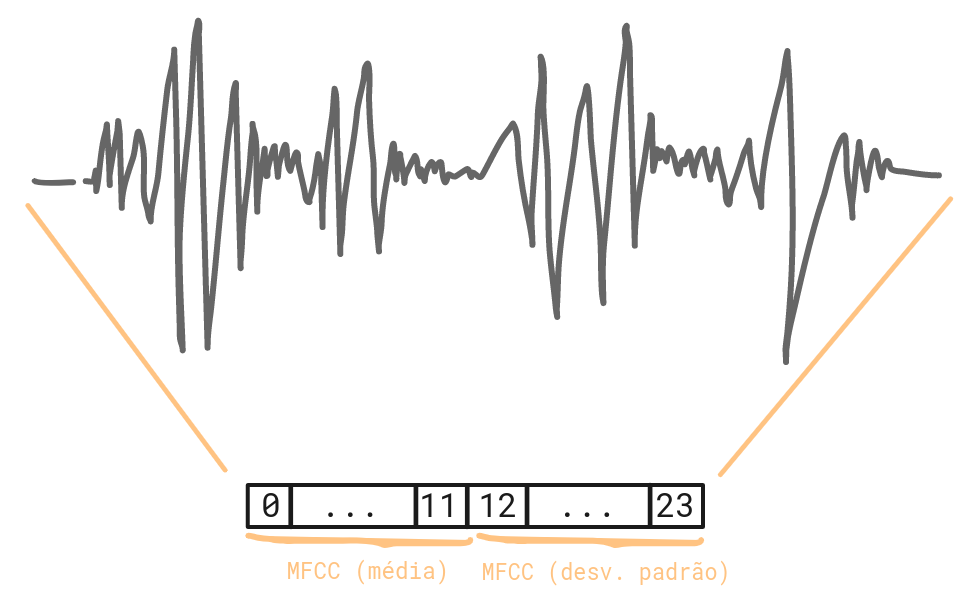

In [13]:
features = np.hstack([mfccs_mean, mfccs_std])

## Aplicando o pré-processamento em todos arquivos

In [14]:
processed_data = np.zeros((len(df), len(features)))

for i, filename in tqdm(enumerate(df.filename)):
    audio_path = os.path.join(path, "audio", filename)
    # Dados do audio (x) e taxa de amostragem (sr).
    x, sr = librosa.load(audio_path)
    # MFCCs
    mfccs = librosa.feature.mfcc(y=x, n_mfcc=13, sr=sr)
    mfccs_mean = mfccs.mean(axis=1)[1:]
    mfccs_mean = mfccs.mean(axis=1)[1:]
    mfccs_std = mfccs.std(axis=1)[1:]
    # Feature vector
    processed_data[i] = np.hstack([mfccs_mean, mfccs_std])
    

# Append dos labels
processed_data = np.hstack([processed_data, df.category.values.reshape((-1, 1))])

400it [01:08,  5.86it/s]


# Divisão do banco de dados em treino e teste

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
train, test = train_test_split(processed_data, test_size=0.2, stratify=processed_data[:,-1])
X_train, y_train = train[:,:-1], train[:,-1]
X_test, y_test = test[:,:-1], test[:,-1]

In [17]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (320, 24)
y_train:  (320,)
X_test:  (80, 24)
y_test:  (80,)


# Os seguintes algoritmos serão avaliados:

- K-Nearest Neighbors (KNN)
- Naive Bayes
- Árvores de Decisão
- Multilayer Perceptron (MLP)

Para isso, será utilizado Cross Validation com 10 folds para otimização dos hipermarâmetros, e em seguido os algoritmos serão comparados com base na partição de teste.

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score

# Otimizando os hiperparâmetros

Para otimização dos hiper-parâmetros, será utilizado a função `GridSearchCV` que avalia o algoritmo com todas combinações de parâmetros passados.

## KNN

In [19]:
from sklearn.neighbors import KNeighborsClassifier

In [20]:
grid_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
}

knn_cv = GridSearchCV(KNeighborsClassifier(), grid_params, scoring="accuracy", cv=10, n_jobs=-1)
knn_cv.fit(X_train, y_train)

# Melhores hiperparametros
knn_params = knn_cv.best_params_
print("Melhores hiperparametros: ")
knn_params

Melhores hiperparametros: 


{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}

## Naive Bayes

In [21]:
from sklearn.naive_bayes import GaussianNB

In [22]:
grid_params = {
    'var_smoothing': [1e-9,1e-7,1e-5,1e-3,1e-1]
}

nb_cv = GridSearchCV(GaussianNB(), grid_params, scoring="accuracy", cv=10, n_jobs=-1)
nb_cv.fit(X_train, y_train)

# Melhores hiperparametros
nb_params = nb_cv.best_params_
print("Melhores hiperparametros: ")
nb_params

Melhores hiperparametros: 


{'var_smoothing': 0.001}

## Árvore de Decisão

In [23]:
from sklearn.tree import DecisionTreeClassifier

In [24]:
grid_params = {
    'criterion': ['gini','entropy', 'log_loss'],
    'min_samples_split': [2, 4, 8, 16, 32],
    'min_samples_leaf': [2, 4, 8, 16, 32],
}

dt_cv = GridSearchCV(DecisionTreeClassifier(), grid_params, scoring="accuracy", cv=10, n_jobs=-1)
dt_cv.fit(X_train, y_train)

# Melhores hiperparametros
dt_params = dt_cv.best_params_
print("Melhores hiperparametros: ")
dt_params

Melhores hiperparametros: 


{'criterion': 'log_loss', 'min_samples_leaf': 4, 'min_samples_split': 8}

## MLP

In [25]:
from sklearn.neural_network import MLPClassifier

In [ ]:
grid_params = {
    'hidden_layer_sizes': [(128), (128,128), (128,128,64)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01]
}

mlp_cv = GridSearchCV(MLPClassifier(max_iter=400), grid_params, scoring="accuracy", cv=10, n_jobs=-1)
mlp_cv.fit(X_train, y_train)

In [27]:
# Melhores hiperparametros
mlp_params = mlp_cv.best_params_
print("Melhores hiperparametros: ")
mlp_params

Melhores hiperparametros: 


{'activation': 'tanh',
 'alpha': 0.001,
 'hidden_layer_sizes': 128,
 'learning_rate': 'invscaling',
 'learning_rate_init': 0.01,
 'solver': 'adam'}

## Resultados do 10-fold Cross Validation

In [28]:
models = [knn_cv, nb_cv, dt_cv, mlp_cv]
results = []

for model in models:
    
    model_results = []
    best_idx = np.argmin(model.cv_results_['rank_test_score'])
    
    for fold in range(10):
        key = f"split{fold}_test_score"
        best_acc = model.cv_results_[key][best_idx]
        model_results.append(best_acc)
        
    results.append(model_results)
    

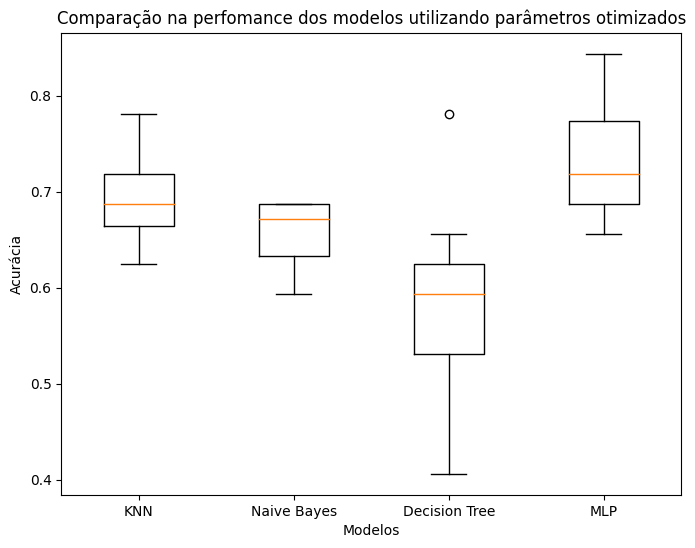

In [29]:
plt.figure(figsize=(8,6))
plt.boxplot(x=results,labels=["KNN", "Naive Bayes", "Decision Tree", "MLP"])
plt.xlabel('Modelos')
plt.ylabel('Acurácia')
plt.title('Comparação na perfomance dos modelos utilizando parâmetros otimizados')
plt.show()

# Avaliando os modelos na partição de teste

Uma vez obtidos os melhores hiperparâmetros pelo *Cross Validation* podemos aplicar os algoritmos com os melhores hiper-parâmetros. Dessa vez, usaremos a partição completa de treino, sem validação.

In [30]:
classes = knn_cv.classes_

# INicializando os algoritmos com os hiperparametros otimizados
knn_model = KNeighborsClassifier(**knn_params)
nb_model = GaussianNB(**nb_params)
dt_model = DecisionTreeClassifier(**dt_params)
mlp_model = MLPClassifier(max_iter=400, **mlp_params)

models = {"KNN": knn_model, "Naive Bayes": nb_model, "Decision Tree": dt_model, "MLP": mlp_model}

Calculando acurácia e matriz de confusão para cada algoritmo.

KNN accuracy:  0.7125
Naive Bayes accuracy:  0.6875
Decision Tree accuracy:  0.6
MLP accuracy:  0.7625


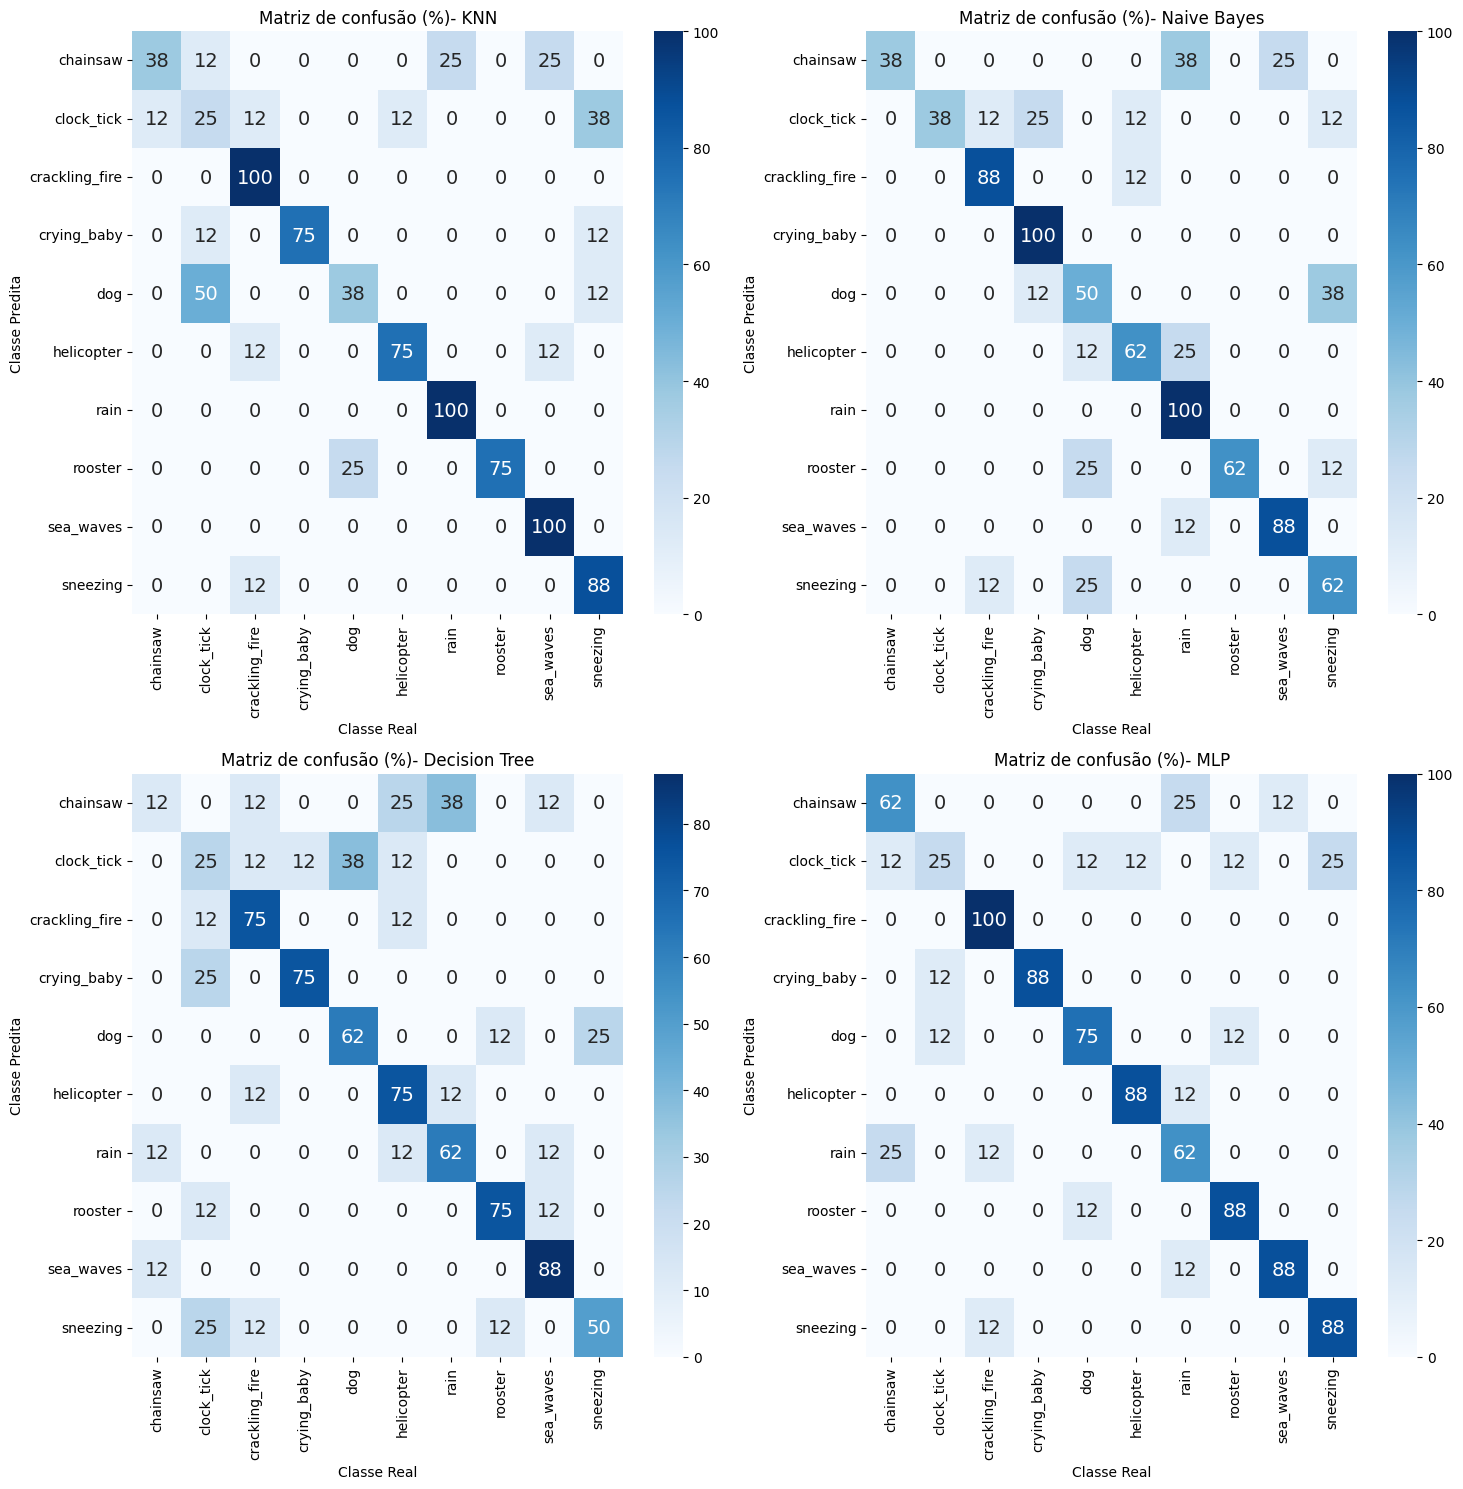

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

for i, (name, model) in enumerate(models.items()):
    
    # Modelo aplicado na particao de treino completa
    model.fit(X_train, y_train)
    
    # Predictions
    preds = model.predict(X_test)
    
    # Acurácia
    print(f'{name} accuracy: ', accuracy_score(y_test, preds))
    
    # Matriz de confusão
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm*100/np.sum(cm, axis=1), fmt=".0f", ax=ax[i//2, i%2], annot=True, cmap='Blues', 
                xticklabels=classes, 
                yticklabels=classes,
                annot_kws={'fontsize': 14})
    ax[i//2, i%2].set_title(f'Matriz de confusão (%)- {name}')
    ax[i//2, i%2].set_xlabel('Classe Real')
    ax[i//2, i%2].set_ylabel('Classe Predita')

fig.tight_layout()
plt.show()

Observando a acurácia obtida por cada modelo e a matriz de confusão, é possível destacar o algoritmo MLP, o qual obteve, aproximadamente, 76.25% de acurácia. Enquanto isso, o segundo algoritmo com melhor desempenho obteve 71.25%, o algoritmo KNN.

Para uma melhor comparação entre os melhores modelos, podemos visualizar a métrica F1-Score por classe. Essa métrica é interessante por combinar a Precision e Recall por meio de uma média harmônica.

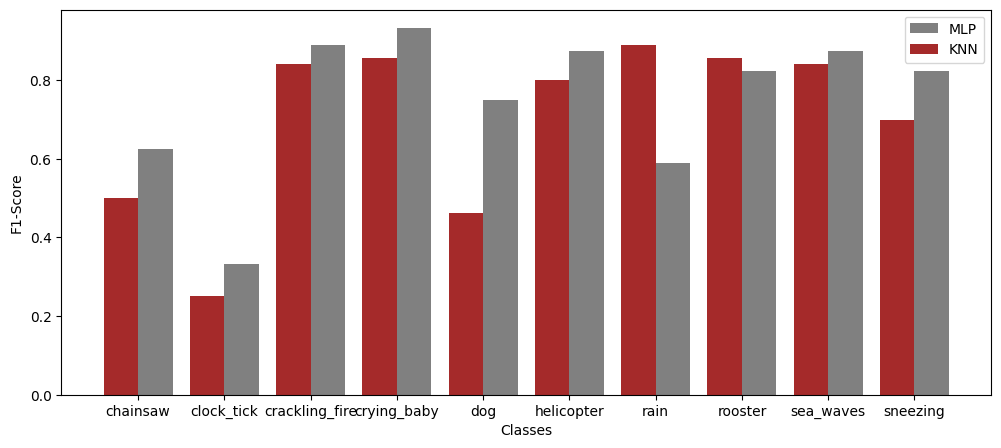

In [32]:
# MLP
preds = mlp_model.predict(X_test)
# Matriz de confusão
cm = confusion_matrix(y_test, preds)
# Metricas
mlp_precision = (cm/np.sum(cm, axis=1)).diagonal()
mlp_recall = (cm/np.sum(cm, axis=0)).diagonal()
mlp_f1_score = 2*(mlp_precision*mlp_recall)/(mlp_precision+mlp_recall)

# KNN
preds = knn_model.predict(X_test)
# Matriz de confusão
cm = confusion_matrix(y_test, preds)
# Metricas
knn_precision = (cm/np.sum(cm, axis=1)).diagonal()
knn_recall = (cm/np.sum(cm, axis=0)).diagonal()
knn_f1_score = 2*(knn_precision*knn_recall)/(knn_precision+knn_recall)

x = np.arange(len(classes))

# Plot do f1-score para cada classe e melhores modelos
plt.figure(figsize=(12,5))
plt.xticks(x, classes)
plt.bar(x = x+0.2, height = mlp_f1_score, width=0.4, color='gray', label='MLP')
plt.bar(x = x-0.2, height = knn_f1_score, width=0.4, color='brown', label='KNN')
plt.ylabel("F1-Score")
plt.xlabel("Classes")
plt.legend()
fig.tight_layout()
plt.show()

Observa-se que o algoritmo MLP foi superior ao KNN considerando a métrica F1-Score em quase todas as classes, com exceção de *rain* e *rooster*.

## Diferença absoluta

Um método para comparação de algoritmos é chamado de Diferença Absoluta, ele pode ser dadao pela seguinte fórmula:

$$
diferenca\ absoluta(A_s - A_p)=\frac{media(A_s - A_p)}{dp(A_s - A_p)}
 $$
 
Utilizando os dados obtidos anteriormente. é possível visualizar a diferença absoluta entre os algoritmos MLP e KNN.

In [ ]:
mlp_results = np.array(results[3])
knn_results = np.array(results[0])

dif_absoluta = np.mean(mlp_results - knn_results) / np.std(mlp_results - knn_results)

print(f'Diferença absoluta: {dif_absoluta}')

Diferença absoluta: 0.5746957711326908

# Conclusão

### Desafio
O maior desafio foi encontrar uma maneira adequada de representar cada áudio como um vetor de *features*. Isso foi possível com a técnica MFCC, que permitiu reduzir cada áudio de 5 segundos em um vetor de 24 posições. Esse vetor, por sua vez, foi utilizado como entrada para todos os algoritmos. Tal representação trouxe resultados satisfatórios, mas é importante, futuramente, avaliar outras maneiras de extrair *features* de áudios.

### Resultado
Sabe-se que os algoritmos de *Machine Learning* avaliados são simples, e portanto não são o estado da arte para classificação de áudios. Considerando isso, os resultados apresentados foram razoáveis, sendo que o melhor algoritmo, MLP, obteve aproximadamente 76% de acurácia. O que pode explicar tal resultado, é a maior complexidade do algoritmo MLP e sua capacidade de reconhecer padrões mais complexos.

### Problemas
O banco de dados utilizado apresenta poucos exemplos por classe, o que certamente prejudica a capacidade de classificação dos modelos.